<img src="spam.jpg" />

# Spam Classifier

### Objectif : Concevoir un classifieur de détection automatique de SPAM.

La collection SMS Spam est un ensemble de messages SMS marqués qui ont été collectés pour la recherche sur les SMS Spam. Elle contient un ensemble de messages SMS en anglais de 5 574 messages, étiquetés selon qu'ils sont ham (légitimes) ou spam.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import string

In [2]:
df = pd.read_csv('spam.csv',encoding = "latin-1")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
df.drop(['Unnamed: 2', 'Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
df.rename(columns={"v1": "target", "v2": "text"},inplace=True)

In [5]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.describe()

,target,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


# EDA + Preprocessing

In [7]:
df['target'].value_counts()

ham     4825
spam     747
Name: target, dtype: int64

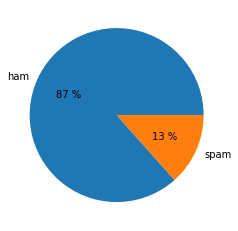

In [8]:
plt.pie(df["target"].value_counts(),labels=["ham","spam"],autopct="%.0f %%")
plt.show()

### Valeurs en double

In [9]:
df.duplicated().value_counts()

False    5169
True      403
dtype: int64

In [10]:
df.drop_duplicates(inplace=True) # (pour Noli,inplace supprimer directement sur la df)

In [11]:
df.duplicated().value_counts() # Verification apres suppression

False    5169
dtype: int64

# Features extraction

#### Longueur du texte

In [12]:
df['length'] = df['text'].str.len()

In [13]:
df.head() # Verification

,target,text,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


#### Nombre de mots

In [14]:
df['words_count'] = df['text'].apply(lambda x: len(x.split(" ")))

In [15]:
df.head() # Verification

,target,text,length,words_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28
3,ham,U dun say so early hor... U c already then say...,49,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13


#### Nombre de majuscules

In [16]:
df['uppercases_count'] = df['text'].str.findall(r'[A-Z]').str.len()

In [17]:
df.head() # Verification

,target,text,length,words_count,uppercases_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3
1,ham,Ok lar... Joking wif u oni...,29,6,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,10
3,ham,U dun say so early hor... U c already then say...,49,11,2
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,2


#### Nombre de minuscules

In [18]:
df['lowercases_count'] = df['text'].str.findall(r'[a-z]').str.len()

In [19]:
df.head()

,target,text,length,words_count,uppercases_count,lowercases_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3,80
1,ham,Ok lar... Joking wif u oni...,29,6,2,16
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,10,87
3,ham,U dun say so early hor... U c already then say...,49,11,2,31
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,2,45


#### Presence d'un numéro de téléphone

In [20]:
def isPhoneNumberInText(txt):
    if bool(re.search("(\d{2})", txt)):
        return 1
    else:
        return 0

In [21]:
df['phone_number_sequence'] = df['text'].map(isPhoneNumberInText)

In [22]:
df.head() # Verification

,target,text,length,words_count,uppercases_count,lowercases_count,phone_number_sequence
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3,80,0
1,ham,Ok lar... Joking wif u oni...,29,6,2,16,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,10,87,1
3,ham,U dun say so early hor... U c already then say...,49,11,2,31,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,2,45,0


In [23]:
df.groupby(['target'])['phone_number_sequence'].sum()

target
ham      97
spam    580
Name: phone_number_sequence, dtype: int64

Text(0.5, 1.0, 'le rapport ham/spam quand il y a au mois 2 chiffres de suites')

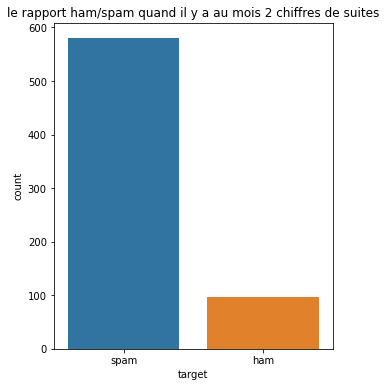

In [24]:
df1 = df[df['phone_number_sequence'] == 1]
plt.figure(figsize=(5,6),)
sns.countplot(x=df1['target']).set_title('le rapport ham/spam quand il y a au mois 2 chiffres de suites')

#### Présence d'une url ou d'un mail

In [25]:
def isUrlMailInText(txt):
    if bool(re.search("\.[a-z]{2,3}(\.|\s|$)|(https?:\/\/|www\.)[a-zA-Z0-9-_\.]+", txt)):
        return 1
    else:
        return 0

In [26]:
df['url_or_mail'] = df['text'].map(isUrlMailInText)

In [27]:
df.head() # Verification

,target,text,length,words_count,uppercases_count,lowercases_count,phone_number_sequence,url_or_mail
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3,80,0,0
1,ham,Ok lar... Joking wif u oni...,29,6,2,16,0,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,10,87,1,0
3,ham,U dun say so early hor... U c already then say...,49,11,2,31,0,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,2,45,0,0


In [28]:
df.groupby(['target'])['url_or_mail'].sum()

target
ham     175
spam    116
Name: url_or_mail, dtype: int64

Text(0.5, 1.0, "Rapport ham/spam si présence d'une url")

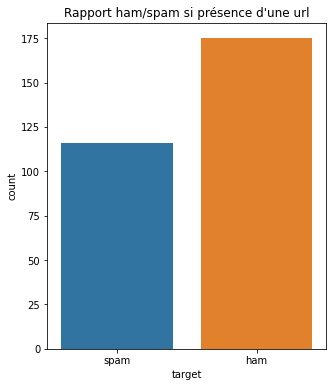

In [29]:
df1 = df[df['url_or_mail'] == 1]
plt.figure(figsize=(5,6),)
sns.countplot(x=df1['target']).set_title('Rapport ham/spam si présence d\'une url')

#### Nombre de caractères spéciaux

In [30]:
def countSpecialCharInText(txt):
    return len(re.findall("[$&+:;=?@#|'<>^*()%!-]", txt))

In [31]:
df['special_char_count'] = df['text'].map(countSpecialCharInText)

In [32]:
df.head() # Verification

,target,text,length,words_count,uppercases_count,lowercases_count,phone_number_sequence,url_or_mail,special_char_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3,80,0,0,0
1,ham,Ok lar... Joking wif u oni...,29,6,2,16,0,0,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,10,87,1,0,5
3,ham,U dun say so early hor... U c already then say...,49,11,2,31,0,0,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,2,45,0,0,1


Text(0.5, 1.0, 'Moyenne ham/spam des carac.spéciaux')

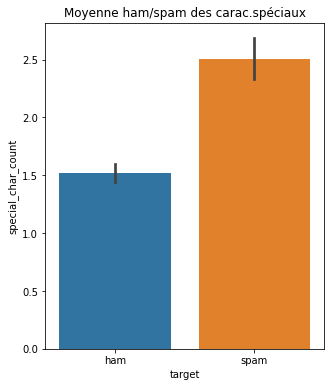

In [33]:
plt.figure(figsize=(5,6),)
sns.barplot(data = df, x="target",y="special_char_count").set_title('Moyenne ham/spam des carac.spéciaux')

# Wordcloud

#### Préparation

In [60]:
def text_cleaning(text):
    text = str(text).lower() #Converting text into lowercase
    text = re.sub('\[.*?\]','',text) #Removing square brackets from the text
    text = re.sub('https?://\S+|www\.\S+', '', text) #Removing links starting with (https or www)
    text = re.sub('<.*?>+','',text) #Removing <"text"> type of text
    text = re.sub("[%s]" % re.escape(string.punctuation),'',text) #Removing punctuations
    text = re.sub("\n",'',text) #Removing new lines
    text = re.sub('\w*\d\w*','',text) #Removing alphanumeric numbers
    text = re.sub('û÷',"'",text) # Remplacement caractères non encodés
    text = re.sub('åõ',"'",text) # Remplacement caractères non encodés
    return(text)

In [72]:
df['text'] = df['text'].apply(text_cleaning)

In [130]:
strHam = ""
strSpam = ""

for idx, series in df.iterrows():
    if series['target'] == 'ham': 
        strHam += series['text']
        strHam += " "
    else:
        strSpam += series['text']
        strSpam += " "

In [128]:
df['text'].head(25)

0     go until jurong point crazy available only in ...
1                               ok lar joking wif u oni
2     free entry in  a wkly comp to win fa cup final...
3           u dun say so early hor u c already then say
4     nah i dont think he goes to usf he lives aroun...
5     freemsg hey there darling its been  weeks now ...
6     even my brother is not like to speak with me t...
7     as per your request melle melle oru minnaminun...
8     winner as a valued network customer you have b...
9     had your mobile  months or more u r entitled t...
10    im gonna be home soon and i dont want to talk ...
11    six chances to win cash from  to  pounds txt  ...
12    urgent you have won a  week free membership in...
13    ive been searching for the right words to than...
14                    i have a date on sunday with will
15    xxxmobilemovieclub to use your credit click th...
16                                 oh kim watching here
17    eh u remember how  spell his name yes i di

In [135]:
strHam

"go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat ok lar joking wif u oni u dun say so early hor u c already then say nah i dont think he goes to usf he lives around here though even my brother is not like to speak with me they treat me like aids patent as per your request melle melle oru minnaminunginte nurungu vettam has been set as your callertune for all callers press  to copy your friends callertune im gonna be home soon and i dont want to talk about this stuff anymore tonight k ive cried enough today ive been searching for the right words to thank you for this breather i promise i wont take your help for granted and will fulfil my promise you have been wonderful and a blessing at all times i have a date on sunday with will oh kim watching here eh u remember how  spell his name yes i did he v naughty make until i v wet fine if that's the way u feel that's the way its gota b is that seriously how you spell his name i\x89'm going

<Figure size 432x288 with 0 Axes>

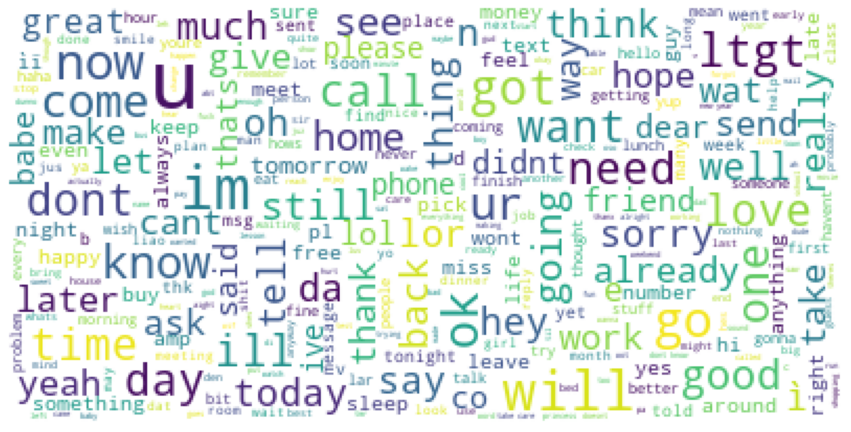

In [187]:
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud().generate(strHam)

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",max_words=len(strHam),max_font_size=40, relative_scaling=.5).generate(strHam)
plt.figure()
plt.figure( figsize=(15,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Wordcloud des Spam

<Figure size 432x288 with 0 Axes>

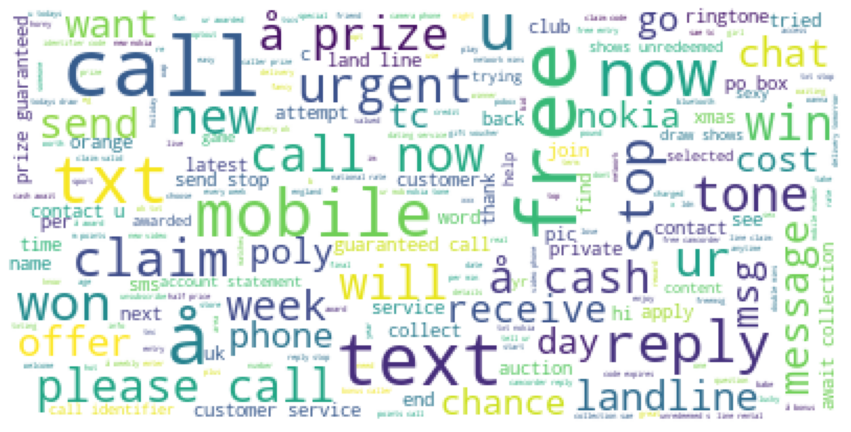

In [148]:
# Generate a word cloud image
wordcloud = WordCloud().generate(strSpam)

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",max_words=len(strSpam),max_font_size=40, relative_scaling=.5).generate(strSpam)
plt.figure()
plt.figure( figsize=(15,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
prize, urgent, free, mobile, please call, call now, cash, chat, win, txt, now, reply, phone, new, now, call, tone, claim, won, chance 

In [149]:
wordsList = ['prize','urgent','free','mobile','please call','call now','cash','chat','win','txt','now','reply','phone','new','now','call','tone','claim','won','chance']

In [184]:
def countWordsInText(txt):
    res = 0
    nb = 0
    for i in wordsList:
        if txt.find(i) != -1:
            nb += 1

    if nb > 3:
        res = 1
    else:
        res = 0

    return res

In [185]:
df['words_fateful_count'] = df['text'].map(countWordsInText)

In [186]:
df.groupby(['target'])['words_fateful_count'].sum()

target
ham      17
spam    225
Name: words_count, dtype: int64

In [174]:
df

,target,text,length,words_count,uppercases_count,lowercases_count,phone_number_sequence,url_or_mail,special_char_count
0,ham,go until jurong point crazy available only in ...,111,0,3,80,0,0,0
1,ham,ok lar joking wif u oni,29,0,2,16,0,0,0
2,spam,free entry in a wkly comp to win fa cup final...,155,0,10,87,1,0,5
3,ham,u dun say so early hor u c already then say,49,0,2,31,0,0,0
4,ham,nah i dont think he goes to usf he lives aroun...,61,0,2,45,0,0,1
...,...,...,...,...,...,...,...,...,...
5567,spam,this is the time we have tried contact u u h...,161,1,9,92,1,0,3
5568,ham,will ì b going to esplanade fr home,37,0,1,26,0,0,1
5569,ham,pity was in mood for that soany other suggest...,57,0,2,39,0,1,2
5570,ham,the guy did some bitching but i acted like id ...,125,0,2,97,0,0,1
